<a href="https://colab.research.google.com/github/2020-nlp-c/nlp-statisticsmodel/blob/master/jjc/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
doc_ls = []

doc = 'Cute Kitty'
doc_ls.append(doc)
doc = 'Eat rice or cake'
doc_ls.append(doc)
doc = 'Kitty and hamster'
doc_ls.append(doc)
doc = 'Eat bread'
doc_ls.append(doc)
doc = 'Rice, bread and cake'
doc_ls.append(doc)
doc = 'Cute hamster eats bread and cake'
doc_ls.append(doc)

doc_ls

['Cute Kitty',
 'Eat rice or cake',
 'Kitty and hamster',
 'Eat bread',
 'Rice, bread and cake',
 'Cute hamster eats bread and cake']

In [ ]:
import numpy as np
import itertools
import pandas as pd
import nltk
from nltk.tokenize import WordPunctTokenizer
import copy
from nltk.stem import WordNetLemmatizer

# 임시, 한글용, konlpy로 바꿔야할듯
from ekonlpy.sentiment import MPCK

class LDA():
    def __init__(self, doc_list, alpha, k, beta):
        self.a = alpha
        self.k = k
        self.beta = beta
        tokens = []
        self.doc_num = len(doc_list)
        self.seta_df = pd.DataFrame(list(range(self.k)), columns = ['topic']).set_index('topic')
        STOPWORDS = ['or', 'and', ',']
        for i, doc in enumerate(doc_list):
            # 한글일 때 다음 주석 전까지 주석처리
            for sw in STOPWORDS:
                doc = doc.replace(sw, '')
            this_token = WordPunctTokenizer().tokenize(doc.lower())
            lm = WordNetLemmatizer()
            this_token = [lm.lemmatize(w, pos="v") for w in this_token]
            # this_token = MPCK().tokenize(doc)
            tokens.append([i, this_token, len(this_token)])
            
        token_df = pd.DataFrame(tokens, columns = ['d#', 'words', 'count'])
        self.token_df = token_df.set_index('d#')
    
    def topic_set(self):
        total_tokens = list(itertools.chain(*list(self.token_df['words'])))
        self.eta_df = pd.DataFrame(set(total_tokens), columns=['word']).set_index('word')
        init_topic = np.random.randint(self.k, size=len(total_tokens))

        # 한글로 할 시 주석처리
        # 강사님 랜덤과 결과 비교용
        init_topic = np.asarray([0,1,0,1,0,1,1,0,0,0,1,0,1,1,1,0,0])

        doc_count = []
        for doc in self.token_df.iloc:
            doc_count.extend([doc.name for i in range(doc['count'])])

        self.topic_df = pd.DataFrame(list(zip(total_tokens, init_topic, doc_count)), columns = ['tokens', 'topic', 'd#'])
        return self.topic_df

    # Train
    def cal_topic(self):
        # 최초 seta, eta 계산
        for j in range(self.k):
            fdist = nltk.FreqDist(list(self.topic_df[self.topic_df['topic'] == j]['tokens']))
            self.eta_df['topic_{}'.format(j)] = pd.DataFrame(list(zip(fdist.keys(),fdist.values())),columns = ['word', 'count']).set_index('word')['count']
        self.eta_df = self.eta_df.fillna(0)+self.beta
        
        for dn in range(self.doc_num):
            fdist = nltk.FreqDist(list(self.topic_df[self.topic_df['d#'] == dn]['topic']))
            self.seta_df['doc_{}'.format(dn)] = pd.DataFrame(list(zip(fdist.keys(), fdist.values())), columns = ['topic', 'count']).set_index('topic')['count']
        self.seta_df = self.seta_df.fillna(0)+self.a
        count = 0
        while True:
            temp_topics = list(self.topic_df['topic'])

            for word in self.topic_df.iloc:
                this_word = word['tokens']
                this_topic = word['topic']
                this_doc = word['d#']
                # print(this_word, this_topic, this_doc)
                self.seta_df.loc[this_topic, 'doc_{}'.format(this_doc)] -= 1
                self.eta_df.loc[this_word, 'topic_{}'.format(this_topic)] -= 1

                # 각각의 확률 계산, Topic 1이라 칠 경우, Topic 2라 칠 경우
                pldas = []
                for j in range(self.k):
                    ptopic = self.seta_df['doc_{}'.format(this_doc)][j] / self.seta_df['doc_{}'.format(this_doc)].sum()
                    pword = self.eta_df['topic_{}'.format(j)][this_word] / self.eta_df['topic_{}'.format(j)].sum()
                    pldas.append(ptopic * pword)
                
                new_topic = pldas.index(max(pldas))
                # print(new_topic)
                # 데이터프레임 값 변경
                self.topic_df.loc[word.name, 'topic'] = new_topic
                
                self.seta_df.loc[new_topic, 'doc_{}'.format(this_doc)] += 1
                self.eta_df.loc[this_word, 'topic_{}'.format(new_topic)] += 1

            if (count>100) & (temp_topics == list(self.topic_df['topic'])):
                break
            count+=1

        return self.topic_df

    # Test
    def predict(self, new_data):
        STOPWORDS = ['or', 'and', ',']
        for sw in STOPWORDS:
            new_data = new_data.replace(sw, '')
        test_token = WordPunctTokenizer().tokenize(new_data.lower())
        lm = WordNetLemmatizer()
        test_token = [lm.lemmatize(w, pos="v") for w in test_token]

        word_topics = []
        for token in test_token:
            temp = list(self.score_df[token])
            topic = temp.index(max(temp))
            word_topics.append(topic)
            print('{} : Topic {}'.format(token, topic))
        doc_count = 0

        for j in range(self.k):
            temp_count = word_topics.count(j)
            if temp_count > doc_count:
                doc_topic = j
                doc_count = temp_count
        print('Doc Topic {}'.format(doc_topic))
    
    # Score
    def score(self):
        score_ls = []
        for j in range(self.k):
            temp = []
            for word in self.eta_df.iloc:
                temp.append(word[j] / self.eta_df['topic_{}'.format(j)].sum())
            score_ls.append(temp)

        score_df = pd.DataFrame(score_ls, columns = self.eta_df.index)
        score_df.index.name = 'Topic'
        self.score_df = score_df
        return score_df


In [ ]:
lda = LDA(doc_ls, 0.1, 2, 0.001)

In [ ]:
lda.token_df

,words,count
d#,,
0,"[cute, kitty]",2
1,"[eat, rice, cake]",3
2,"[kitty, hamster]",2
3,"[eat, bread]",2
4,"[rice, bread, cake]",3
5,"[cute, hamster, eat, bread, cake]",5


In [ ]:
lda.topic_set()

,tokens,topic,d#
0,cute,0,0
1,kitty,1,0
2,eat,0,1
3,rice,1,1
4,cake,0,1
5,kitty,1,2
6,hamster,1,2
7,eat,0,3
8,bread,0,3
9,rice,0,4


In [ ]:
lda.cal_topic()

,tokens,topic,d#
0,cute,1,0
1,kitty,1,0
2,eat,0,1
3,rice,0,1
4,cake,0,1
5,kitty,1,2
6,hamster,1,2
7,eat,0,3
8,bread,0,3
9,rice,0,4


In [ ]:
lda.eta_df

,topic_0,topic_1
word,,
bread,3.001,0.001
cute,0.001,2.001
kitty,0.001,2.001
rice,2.001,0.001
eat,3.001,0.001
hamster,0.001,2.001
cake,3.001,0.001


In [ ]:
lda.seta_df

,doc_0,doc_1,doc_2,doc_3,doc_4,doc_5
topic,,,,,,
0,0.1,3.1,0.1,2.1,3.1,3.1
1,2.1,0.1,2.1,0.1,0.1,2.1


In [ ]:
result = lda.score()
lda.score_df

word,bread,cute,kitty,rice,eat,hamster,cake
Topic,,,,,,,
0,0.272645,0.000091,0.000091,0.181793,0.272645,0.000091,0.272645
1,0.000166,0.333111,0.333111,0.000166,0.000166,0.333111,0.000166


In [ ]:
lda.predict('bread kitty rice')

bread : Topic 0
kitty : Topic 1
rice : Topic 0
Doc Topic 0


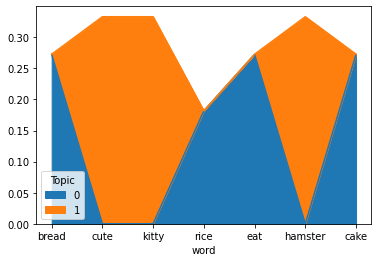

In [ ]:
# library
import matplotlib.pyplot as plt
import numpy as np
# plot
lda.score_df.T.plot.area()
plt.show()

# Pickle 변수로 저장, 사이킷런 joblib 사용, 파일로 저장

In [ ]:
import pickle

# 피클 변수로 저장, 불러오기
saved_model = pickle.dumps(lda)
lda_from_pickle = pickle.loads(saved_model)

In [ ]:
lda.score_df

In [ ]:
from sklearn.externals import joblib

# 학습된 모델 Pickle 파일로 저장
joblib.dump(lda, 'filename.pkl')

# Pickle 파일 불러와 모델 저장
lda_from_joblib = joblib.load('filename.pkl') 

In [ ]:
lda_from_joblib.score_df